### 1. Import and data loading

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import time

In [2]:
df = pd.read_csv("../data/chess_games_feature.csv")
df.head()

,WhiteElo,BlackElo,ResultNumeric,EventTypeID,RatingDiff,AvgRating,WhiteIsHigherRated,WhiteRatingAdvantage,ECOID,white_castled,...,white_pawn_moves,black_pawn_moves,white_piece_moves,black_piece_moves,white_center_pawns,black_center_pawns,white_bishop_developed,black_bishop_developed,white_early_queen_out,black_early_queen_out
0,2504,2371,2,0,133,2437.5,1,133,0,1,...,5,5,4,4,2,2,1,1,0,0
1,2487,2596,1,0,109,2541.5,0,-109,0,1,...,4,6,5,3,2,1,1,1,0,0
2,2915,2921,1,0,6,2918.0,0,-6,0,1,...,4,5,5,4,2,1,1,1,0,0
3,2542,2433,2,0,109,2487.5,1,109,10,1,...,2,5,7,5,2,1,1,1,0,0
4,2473,2658,0,0,185,2565.5,0,-185,0,1,...,2,3,7,6,2,1,1,1,0,0


### 2. Prepare data

In [3]:
X = df.drop(['ResultNumeric'], axis=1)
y = df['ResultNumeric']

print(f"Features: {X.shape}")
print(f"Target: {y.shape}")

Features: (3243955, 22)
Target: (3243955,)


### 3. Train test split

In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2,        # 20% for testing
    random_state=42,
    stratify=y
)

### 4. Train model

In [5]:
xgb_model = XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    random_state=42,
    n_jobs=-1,
    eval_metric='mlogloss'
)

In [6]:
start_time = time.time()

xgb_model.fit(X_train, y_train)

training_time = time.time() - start_time
print(f"Training completed in {training_time:.2f} seconds ({training_time/60:.2f} minutes)")

Training completed in 26.36 seconds (0.44 minutes)


### 5. Evaluate

In [7]:
y_pred = xgb_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"\nTest Set Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)\n")

print("Classification Report:\n")
print(classification_report(y_test, y_pred, target_names=['Black Win', 'Draw', 'White Win']))


Test Set Accuracy: 0.5849 (58.49%)

Classification Report:

              precision    recall  f1-score   support

   Black Win       0.56      0.58      0.57    265868
        Draw       0.88      0.27      0.41     83919
   White Win       0.59      0.68      0.63    299004

    accuracy                           0.58    648791
   macro avg       0.67      0.51      0.54    648791
weighted avg       0.61      0.58      0.58    648791



### 6. Confusion Matrix

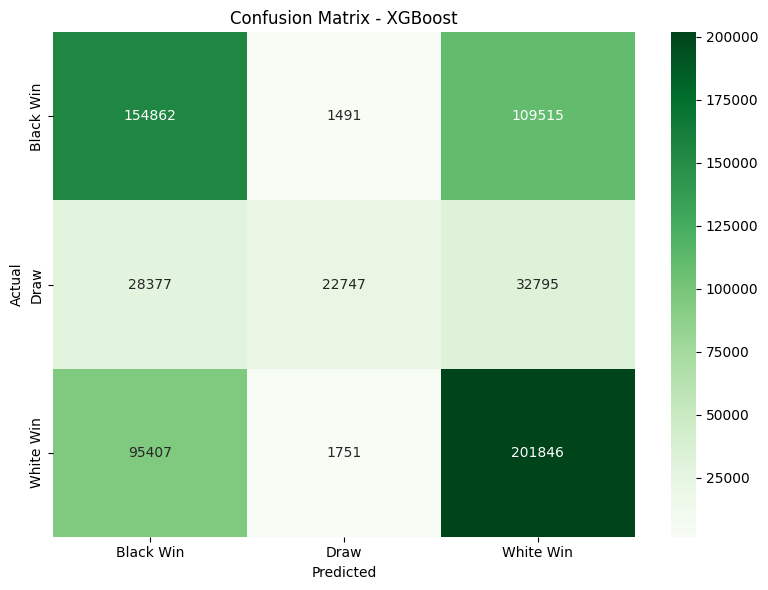

In [8]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Black Win', 'Draw', 'White Win'],
            yticklabels=['Black Win', 'Draw', 'White Win'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix - XGBoost')
plt.tight_layout()
plt.show()

### 7. Feature Importance

                   Feature  Importance
6     WhiteRatingAdvantage    0.348695
4                AvgRating    0.298455
3               RatingDiff    0.091390
0                 WhiteElo    0.069050
1                 BlackElo    0.063595
2              EventTypeID    0.041046
5       WhiteIsHigherRated    0.021638
10          white_captures    0.008295
9            black_castled    0.007146
11          black_captures    0.006709
8            white_castled    0.005125
16      white_center_pawns    0.005069
13        black_pawn_moves    0.004629
15       black_piece_moves    0.004225
12        white_pawn_moves    0.003784
7                    ECOID    0.003712
17      black_center_pawns    0.003431
21   black_early_queen_out    0.003277
19  black_bishop_developed    0.003213
14       white_piece_moves    0.002749
18  white_bishop_developed    0.002707
20   white_early_queen_out    0.002060


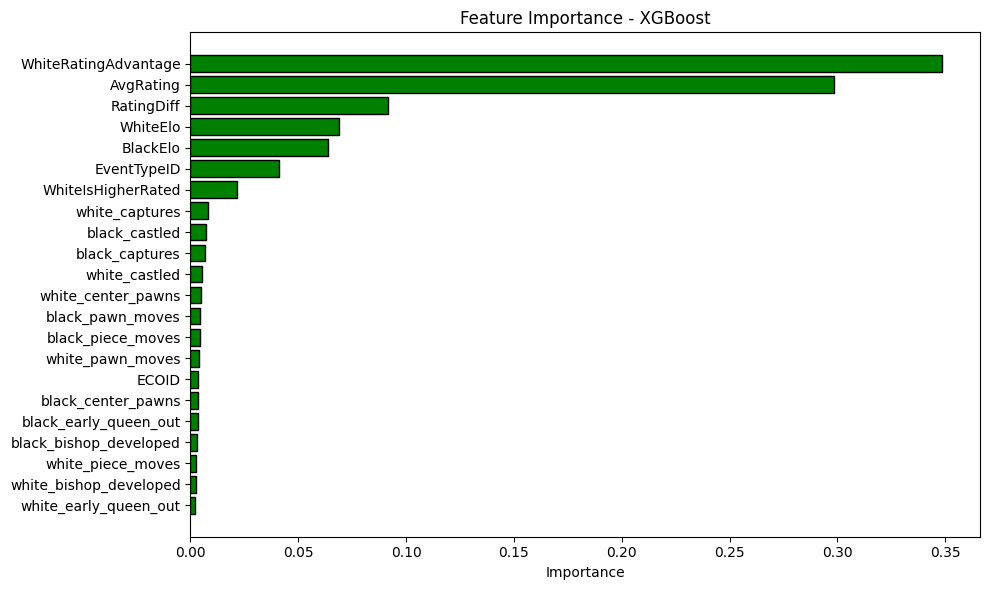

In [9]:
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': xgb_model.feature_importances_
}).sort_values('Importance', ascending=False)

print(importance_df)

plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='green', edgecolor='black')
plt.xlabel('Importance')
plt.title('Feature Importance - XGBoost')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()